### Import Required Packages and Set Options

#### Import Base Libraries

In [296]:
import os
import sys
import git

import numpy as np
import numba as nb
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from functools import partial

In [297]:
sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

#### Put the Main Package Library on the PYTHONPATH

In [203]:
git_repo = git.Repo('.', search_parent_directories=True)
git_root = git_repo.git.rev_parse('--show-toplevel')

sys.path[0] = git_root
sys.path[0]

'/Users/ericlundquist/Repos/rankfm'

#### Dynamically Re-Load all Package Modules on Execution

In [204]:
%load_ext autoreload
%autoreload 2

from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set File Path Constants

In [448]:
REPO_ROOT = os.path.split(git_root)[0]
DATA_ROOT = os.path.join(REPO_ROOT, "data/ml-100k")
print("\n".join([REPO_ROOT, DATA_ROOT]))

/Users/ericlundquist/Repos
/Users/ericlundquist/Repos/data/ml-100k


### Prepare Example Data

#### Load Users Data

In [206]:
users_df = pd.read_csv(os.path.join(DATA_ROOT, "users.csv"))
users_df['agegroup'] = pd.cut(users_df['age'], [0, 30, 45, 100], right=False, labels=False)
users_df = users_df.drop(['age', 'zip_code'], axis=1)
users_df = pd.get_dummies(users_df, prefix_sep='__', columns=['agegroup', 'gender', 'occupation'])
users_df.mean()

user_id                      472.000000
agegroup__0                    0.433722
agegroup__1                    0.348887
agegroup__2                    0.217391
gender__F                      0.289502
gender__M                      0.710498
occupation__administrator      0.083775
occupation__artist             0.029692
occupation__doctor             0.007423
occupation__educator           0.100742
occupation__engineer           0.071050
occupation__entertainment      0.019088
occupation__executive          0.033934
occupation__healthcare         0.016967
occupation__homemaker          0.007423
occupation__lawyer             0.012725
occupation__librarian          0.054083
occupation__marketing          0.027572
occupation__none               0.009544
occupation__other              0.111347
occupation__programmer         0.069989
occupation__retired            0.014846
occupation__salesman           0.012725
occupation__scientist          0.032874
occupation__student            0.207847


#### Load Items Data

In [207]:
items_df = pd.read_csv(os.path.join(DATA_ROOT, "items.csv"))
item_names = items_df[['item_id', 'item_name']]
item_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [208]:
items_df = items_df.drop(['item_name', 'release_date'], axis=1)
items_df.columns = ['item_id'] + ["genre__{}".format(col) for col in items_df.columns[1:]]
items_df.mean()

item_id               841.500000
genre__action           0.149227
genre__adventure        0.080262
genre__animation        0.024970
genre__childrens        0.072533
genre__comedy           0.300238
genre__crime            0.064804
genre__documentary      0.029727
genre__drama            0.431034
genre__fantasy          0.013080
genre__film_noir        0.014269
genre__horror           0.054697
genre__musical          0.033294
genre__mystery          0.036266
genre__romance          0.146849
genre__scifi            0.060048
genre__thriller         0.149227
genre__war              0.042212
genre__western          0.016052
dtype: float64

#### Load Ratings Data

In [385]:
ratings_explicit = pd.read_csv(os.path.join(DATA_ROOT, "ratings.csv"))
ratings_explicit['timestamp'] = pd.to_datetime(ratings_explicit['unix_timestamp'], origin='unix', unit='s')
ratings_explicit['above_average'] = ratings_explicit.groupby('user_id')['rating'].transform(lambda c: np.where(c > c.mean(), 1, 0))
ratings_explicit = ratings_explicit.drop('unix_timestamp', axis=1)
ratings_explicit.mean()

user_id          462.48475
item_id          425.53013
rating             3.52986
above_average      0.54194
dtype: float64

In [386]:
ratings_explicit.head()

,user_id,item_id,rating,timestamp,above_average
0,196,242,3,1997-12-04 15:55:49,0
1,186,302,3,1998-04-04 19:22:22,0
2,22,377,1,1997-11-07 07:18:36,0
3,244,51,2,1997-11-27 05:02:03,0
4,166,346,1,1998-02-02 05:33:16,0


#### Generate Implicit Feedback Ratings Data

In [388]:
ratings_implicit = ratings_explicit[ratings_explicit.rating >= 4].reset_index(drop=True)
ratings_implicit.head()

,user_id,item_id,rating,timestamp,above_average
0,298,474,4,1998-01-07 14:20:06,0
1,253,465,5,1998-04-03 18:34:27,1
2,286,1014,5,1997-11-17 15:38:45,1
3,200,222,5,1997-10-05 09:05:40,1
4,122,387,5,1997-11-11 17:47:39,1


#### Print Final Matrix Shapes

In [389]:
print(ratings_explicit.user_id.nunique(), ratings_explicit.item_id.nunique())
print(ratings_implicit.user_id.nunique(), ratings_implicit.item_id.nunique())

print(ratings_explicit.shape)
print(ratings_implicit.shape)

943 1682
942 1447
(100000, 5)
(55375, 5)


#### Create (Training, Validation) Interactions for Evaluation

In [390]:
print(ratings_implicit.shape)
ratings_implicit.head()

(55375, 5)


,user_id,item_id,rating,timestamp,above_average
0,298,474,4,1998-01-07 14:20:06,0
1,253,465,5,1998-04-03 18:34:27,1
2,286,1014,5,1997-11-17 15:38:45,1
3,200,222,5,1997-10-05 09:05:40,1
4,122,387,5,1997-11-11 17:47:39,1


In [391]:
# ratings_implicit['user_id'] = ratings_implicit['user_id'].astype('str')
# ratings_implicit['item_id'] = ratings_implicit['item_id'].astype('str')
# ratings_implicit.info()

In [392]:
test_pct = 0.25
drop_users = (2, 4)

train_mask = (ratings_implicit.index / ratings_implicit.shape[0]) <  (1 - test_pct)
valid_mask = (ratings_implicit.index / ratings_implicit.shape[0]) >= (1 - test_pct)

interactions_total = ratings_implicit[['user_id', 'item_id']]
interactions_train = ratings_implicit[train_mask][['user_id', 'item_id']]
interactions_valid = ratings_implicit[valid_mask][['user_id', 'item_id']]

# drop some users from the training data to test cold-start functionality
interactions_train = interactions_train[~interactions_train.user_id.isin(drop_users)]

train_users = np.sort(interactions_train.user_id.unique())
valid_users = np.sort(interactions_valid.user_id.unique())
cold_start_users = set(valid_users) - set(train_users)

print("total shape: {}".format(interactions_total.shape))
print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))
print("train users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

total shape: (55375, 2)
train shape: (41479, 2)
valid shape: (13843, 2)
train users: 939
valid users: 902
cold-start users: {2, 915, 4}


In [393]:
iteraction_users = interactions_train.user_id.unique()
iteraction_items = interactions_train.item_id.unique()

#### Create User/Item Features Data for Testing

In [394]:
user_features = users_df[users_df.user_id.isin(iteraction_users)]
print(user_features.shape, users_df.shape)
user_features.head()

(939, 27) (943, 27)


,user_id,agegroup__0,agegroup__1,agegroup__2,gender__F,gender__M,occupation__administrator,occupation__artist,occupation__doctor,occupation__educator,...,occupation__marketing,occupation__none,occupation__other,occupation__programmer,occupation__retired,occupation__salesman,occupation__scientist,occupation__student,occupation__technician,occupation__writer
0,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,6,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [395]:
item_features = items_df[items_df.item_id.isin(iteraction_items)]
print(item_features.shape, items_df.shape)
item_features.head()

(1389, 19) (1682, 19)


,item_id,genre__action,genre__adventure,genre__animation,genre__childrens,genre__comedy,genre__crime,genre__documentary,genre__drama,genre__fantasy,genre__film_noir,genre__horror,genre__musical,genre__mystery,genre__romance,genre__scifi,genre__thriller,genre__war,genre__western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


### Test Out Core Package Functionality

In [396]:
interactions_train.shape, user_features.shape, item_features.shape

((41479, 2), (939, 27), (1389, 19))

In [397]:
interactions_train.dtypes

user_id    int64
item_id    int64
dtype: object

#### Initialize the Model

In [398]:
model = RankFM(factors=10, learning_rate=0.1, regularization=0.01, sigma=0.1)
model

#### Initialize and Inspect Internal Data

In [399]:
%%time
model._init_all(interactions_train, user_features, item_features)

CPU times: user 129 ms, sys: 4.9 ms, total: 134 ms
Wall time: 133 ms


In [400]:
print(len(model.user_id), len(model.user_idx))
print(len(model.item_id), len(model.item_idx))

939 939
1389 1389


In [401]:
print(model.interactions.shape)
print(model.x_uf.shape)
print(model.x_if.shape)

(41479, 2)
(939, 26)
(1389, 18)


In [402]:
print("item weights: {}".format(model.w_i.shape))
print("item feature weights: {}".format(model.w_if.shape))
print("user factors: {}".format(model.v_u.shape))
print("item factors: {}".format(model.v_i.shape))
print("user feature factors: {}".format(model.v_uf.shape))
print("item feature factors: {}".format(model.v_if.shape))

item weights: (1389,)
item feature weights: (18,)
user factors: (939, 10)
item factors: (1389, 10)
user feature factors: (26, 10)
item feature factors: (18, 10)


In [403]:
model.interactions.dtype

dtype('int32')

In [404]:
model.user_items_nb[10]

array([  3,  11,  12,  13,  21,  22,  31,  32,  41,  47,  48,  49,  55,
        57,  58,  60,  61,  63,  68,  70,  71,  86,  87,  88,  94,  95,
        96,  97,  98,  99, 106, 108, 115, 118, 121, 124, 134, 141, 147,
       149, 150, 151, 157, 158, 164, 165, 167, 169, 171, 174, 175, 177,
       178, 180, 183, 187, 190, 191, 193, 194, 196, 199, 201, 205, 208,
       209, 212, 220, 221, 223, 224, 225, 226, 230, 231, 234, 236, 255,
       259, 260, 261, 262, 265, 267, 269, 273, 276, 287, 289, 299, 300,
       302, 307, 310, 311, 312, 313, 315, 338, 341, 342, 343, 349, 356,
       396, 398, 408, 414, 417, 420, 421, 423, 426, 428, 432, 433, 438,
       450, 451, 455, 460, 461, 462, 465, 466, 470, 471, 472, 479, 480,
       481, 482, 485, 486, 489, 490, 494, 497, 498, 499, 502, 504, 505,
       506, 507, 508, 511, 512, 515, 517, 518, 537, 553, 557, 572, 575,
       585, 586, 587, 588, 590, 596, 597, 598, 599, 605, 608, 630, 635,
       636, 638, 639, 640, 641, 645, 646, 647, 659, 662, 667, 66

In [405]:
uf_checker = pd.DataFrame(model.x_uf, columns=user_features.columns[1:])
uf_checker.head()

,agegroup__0,agegroup__1,agegroup__2,gender__F,gender__M,occupation__administrator,occupation__artist,occupation__doctor,occupation__educator,occupation__engineer,...,occupation__marketing,occupation__none,occupation__other,occupation__programmer,occupation__retired,occupation__salesman,occupation__scientist,occupation__student,occupation__technician,occupation__writer
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [406]:
user_features[user_features.user_id.isin(pd.Series([0,1,2,3,4]).map(model.index_to_user))]

,user_id,agegroup__0,agegroup__1,agegroup__2,gender__F,gender__M,occupation__administrator,occupation__artist,occupation__doctor,occupation__educator,...,occupation__marketing,occupation__none,occupation__other,occupation__programmer,occupation__retired,occupation__salesman,occupation__scientist,occupation__student,occupation__technician,occupation__writer
0,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,6,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [407]:
if_checker = pd.DataFrame(model.x_if, columns=item_features.columns[1:])
if_checker.head()

,genre__action,genre__adventure,genre__animation,genre__childrens,genre__comedy,genre__crime,genre__documentary,genre__drama,genre__fantasy,genre__film_noir,genre__horror,genre__musical,genre__mystery,genre__romance,genre__scifi,genre__thriller,genre__war,genre__western
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [408]:
item_features[item_features.item_id.isin(pd.Series([0,1,2,3,4]).map(model.index_to_item))]

,item_id,genre__action,genre__adventure,genre__animation,genre__childrens,genre__comedy,genre__crime,genre__documentary,genre__drama,genre__fantasy,genre__film_noir,genre__horror,genre__musical,genre__mystery,genre__romance,genre__scifi,genre__thriller,genre__war,genre__western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


#### Fit the Model on the Training Data and Profile Computational Performance

In [409]:
interactions_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41479 entries, 0 to 41531
Data columns (total 2 columns):
user_id    41479 non-null int64
item_id    41479 non-null int64
dtypes: int64(2)
memory usage: 972.2 KB


In [412]:
model = RankFM(factors=10, regularization=0.01, sigma=0.1, learning_rate=0.10, learning_schedule='invscaling', learning_exponent=0.25)
model

In [413]:
%%time

model.fit(interactions_train, epochs=50, verbose=True)
# model.fit(interactions_train, item_features=item_features, epochs=50, verbose=True)

/Users/ericlundquist/Repos/rankfm/rankfm/numba_methods.py:131: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 1d, C))
  d_v_uf[p, f] = (x_uf[u][p]) * (v_i[i][f] - v_i[j][f] + np.dot(v_if.T[f], x_if[i] - x_if[j]))
/Users/ericlundquist/Repos/rankfm/rankfm/numba_methods.py:136: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 1d, C))
  d_v_if[q, f] = (x_if[i][q] - x_if[j][q]) * (v_u[u][f] + np.dot(v_uf.T[f], x_uf[u]))



training epoch: 0
log likelihood: -19325.97

training epoch: 1
log likelihood: -15929.67

training epoch: 2
log likelihood: -15303.82

training epoch: 3
log likelihood: -14886.61

training epoch: 4
log likelihood: -14374.69

training epoch: 5
log likelihood: -13640.57

training epoch: 6
log likelihood: -12933.58

training epoch: 7
log likelihood: -12614.83

training epoch: 8
log likelihood: -11986.28

training epoch: 9
log likelihood: -11482.88

training epoch: 10
log likelihood: -11114.6

training epoch: 11
log likelihood: -10845.16

training epoch: 12
log likelihood: -10465.27

training epoch: 13
log likelihood: -10130.08

training epoch: 14
log likelihood: -9874.82

training epoch: 15
log likelihood: -9783.1

training epoch: 16
log likelihood: -9564.08

training epoch: 17
log likelihood: -9348.01

training epoch: 18
log likelihood: -9199.54

training epoch: 19
log likelihood: -9084.24

training epoch: 20
log likelihood: -8864.03

training epoch: 21
log likelihood: -8980.64

trainin

In [414]:
# model.fit_partial(interactions_train, epochs=5, verbose=True)

#### Generate Model Scores

In [415]:
interactions_total.shape

(55375, 2)

In [416]:
%%time
scores = model.predict(interactions_total, cold_start='nan') 

CPU times: user 411 ms, sys: 7.13 ms, total: 418 ms
Wall time: 434 ms


#### Generate TopN Recommendations

In [417]:
all_users = pd.Series(interactions_total.user_id.unique())
print(all_users.shape)
all_users.head(10)

(942,)


0    298
1    253
2    286
3    200
4    122
5    291
6    119
7    167
8    299
9    308
dtype: int64

In [418]:
%%time
top_recs = model.recommend_for_users(all_users, n_items=10, filter_previous=False, cold_start='nan')

CPU times: user 1.25 s, sys: 11.5 ms, total: 1.26 s
Wall time: 916 ms


In [419]:
top_recs.head()

,0,1,2,3,4,5,6,7,8,9
298,174.0,50.0,69.0,71.0,28.0,496.0,79.0,318.0,64.0,22.0
253,50.0,174.0,22.0,69.0,181.0,79.0,64.0,318.0,97.0,127.0
286,83.0,277.0,713.0,181.0,382.0,250.0,275.0,25.0,70.0,258.0
200,121.0,118.0,181.0,1.0,174.0,71.0,96.0,82.0,22.0,228.0
122,191.0,83.0,238.0,197.0,70.0,216.0,498.0,97.0,86.0,208.0


### Evaluate Model Performance on the Validation Data

#### Specify Number of Recommended Items

In [420]:
k = 10

#### Generate Pure-Popularity Baselines

In [421]:
most_popular = interactions_train.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

item_id
50     370
100    294
181    292
98     261
258    258
174    252
127    251
1      235
56     224
286    220
Name: user_id, dtype: int64

In [422]:
test_user_items = interactions_valid.groupby('user_id')['item_id'].apply(set).to_dict()
test_recommends = model.recommend_for_users(list(test_user_items.keys()), cold_start='drop')
test_user_items = {key: val for key, val in test_user_items.items() if key in test_recommends.index}

base_pre = round(np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()]), 3)
base_rec = round(np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()]), 3)

print("number of test users: {}".format(len(test_user_items)))
print("baseline precision: {}".format(base_pre))
print("baseline recall: {}".format(base_rec))

number of test users: 899
baseline precision: 0.102
baseline recall: 0.092


#### Generate Model Performance Validation Metriccs

In [423]:
%%time
model_hit_rate = hit_rate(model, interactions_valid, k=k)

CPU times: user 932 ms, sys: 5.91 ms, total: 938 ms
Wall time: 295 ms


In [424]:
%%time 
model_reciprocal_rank = reciprocal_rank(model, interactions_valid, k=k)

CPU times: user 1.55 s, sys: 12.1 ms, total: 1.56 s
Wall time: 657 ms


In [425]:
%%time 
model_dcg = discounted_cumulative_gain(model, interactions_valid, k=k)

CPU times: user 1.52 s, sys: 10.7 ms, total: 1.53 s
Wall time: 679 ms


In [426]:
%%time
model_precision = precision(model, interactions_valid, k=k)

CPU times: user 1.24 s, sys: 6.27 ms, total: 1.25 s
Wall time: 366 ms


In [427]:
%%time
model_recall = recall(model, interactions_valid, k=k)

CPU times: user 957 ms, sys: 8.7 ms, total: 966 ms
Wall time: 304 ms


In [428]:
print("hit_rate: {}".format(round(model_hit_rate, 3)))
print("reciprocal_rank: {}".format(round(model_reciprocal_rank, 3)))
print("dcg: {}".format(round(model_dcg, 3)))
print("precision: {}".format(round(model_precision, 3)))
print("recall: {}".format(round(model_recall, 3)))

hit_rate: 0.659
reciprocal_rank: 0.291
dcg: 0.616
precision: 0.131
recall: 0.141


#### Generate Item Diversity DataFrame

In [429]:
model_diversity = diversity(model, interactions_valid, k=k)
model_diversity.head(10)

,item_id,cnt_users,pct_users
0,50,393,0.437152
1,100,284,0.315907
2,258,278,0.309232
3,181,256,0.284761
4,174,246,0.273637
5,286,198,0.220245
6,269,192,0.213571
7,191,185,0.205784
8,98,170,0.189099
9,127,160,0.177976


In [430]:
top_item_names = item_names[item_names.item_id.isin(model_diversity.item_id[:10])].set_index('item_id').loc[model_diversity.item_id[:10]].reset_index()
top_item_names = pd.merge(top_item_names, model_diversity, on='item_id', how='inner')
top_item_names

,item_id,item_name,cnt_users,pct_users
0,50,Star Wars (1977),393,0.437152
1,100,Fargo (1996),284,0.315907
2,258,Contact (1997),278,0.309232
3,181,Return of the Jedi (1983),256,0.284761
4,174,Raiders of the Lost Ark (1981),246,0.273637
5,286,"English Patient, The (1996)",198,0.220245
6,269,"Full Monty, The (1997)",192,0.213571
7,191,Amadeus (1984),185,0.205784
8,98,"Silence of the Lambs, The (1991)",170,0.189099
9,127,"Godfather, The (1972)",160,0.177976


In [431]:
coverage = np.mean(model_diversity['cnt_users'] > 0)
round(coverage, 3)

0.231

In [432]:
nonzero = model_diversity[model_diversity.cnt_users > 0]
entropy = -np.sum(nonzero['pct_users'] * np.log2(nonzero['pct_users']))
round(entropy, 2)

35.83

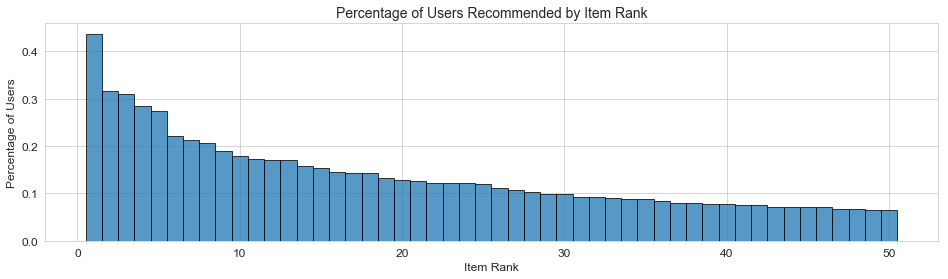

In [433]:
fig, axes = plt.subplots(1, 1, figsize=[16, 4])
N = 50

topN = model_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

### QA the Predict/Recommend/Similarity Methods

#### Generate Model Scores for Test User/Items

In [434]:
mask = (interactions_valid.user_id.isin(interactions_train.user_id)) & (interactions_valid.item_id.isin(interactions_train.item_id))
print(interactions_valid.shape)
print(interactions_valid[mask].shape)

(13843, 2)
(13756, 2)


In [435]:
scores_miss = model.predict(interactions_valid, cold_start='nan')
scores_drop = model.predict(interactions_valid, cold_start='drop')

print(scores_miss.shape)
print(scores_drop.shape)

(13843,)
(13756,)


#### Spot-Check Some User Recommendations

In [436]:
len(train_users), len(valid_users), cold_start_users

(939, 902, {2, 4, 915})

In [437]:
recommendations = model.recommend_for_users(valid_users, n_items=10, filter_previous=True, cold_start='nan')
print(recommendations.shape)
recommendations.head(10)

(902, 10)


,0,1,2,3,4,5,6,7,8,9
1,172.0,408.0,475.0,8.0,189.0,179.0,4.0,216.0,1012.0,204.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,751.0,270.0,333.0,258.0,271.0,307.0,748.0,302.0,313.0,326.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,175.0,168.0,154.0,181.0,250.0,174.0,68.0,179.0,176.0,195.0
6,603.0,654.0,179.0,216.0,8.0,657.0,663.0,285.0,203.0,705.0
7,176.0,23.0,173.0,673.0,164.0,50.0,70.0,357.0,478.0,69.0
8,96.0,64.0,202.0,265.0,173.0,168.0,98.0,226.0,100.0,69.0
9,272.0,269.0,302.0,127.0,316.0,315.0,100.0,197.0,603.0,258.0
10,23.0,427.0,318.0,180.0,479.0,179.0,89.0,79.0,187.0,12.0


In [438]:
user_id = 5
user_recs = recommendations.loc[user_id]
user_item_names = item_names[item_names.item_id.isin(user_recs)].set_index('item_id').loc[user_recs]
user_item_names

,item_name
item_id,
175.0,Brazil (1985)
168.0,Monty Python and the Holy Grail (1974)
154.0,Monty Python's Life of Brian (1979)
181.0,Return of the Jedi (1983)
250.0,"Fifth Element, The (1997)"
174.0,Raiders of the Lost Ark (1981)
68.0,"Crow, The (1994)"
179.0,"Clockwork Orange, A (1971)"
176.0,Aliens (1986)


#### Look at Similar Movies for a Few Recommended Movies

In [442]:
most_similar_items = model.similar_items(68.0)
most_similar_names = item_names.set_index('item_id').loc[most_similar_items]
most_similar_names

,item_name
item_id,
184,Army of Darkness (1993)
217,Bram Stoker's Dracula (1992)
219,"Nightmare on Elm Street, A (1984)"
559,Interview with the Vampire (1994)
550,Die Hard: With a Vengeance (1995)
17,From Dusk Till Dawn (1996)
746,Real Genius (1985)
53,Natural Born Killers (1994)
413,Tales from the Crypt Presents: Bordello of Blo...


### Look at the Movies with the Highest/Lowest Model Weights

In [443]:
item_weights = pd.DataFrame({'item_idx': np.arange(len(model.w_i)), 'w_item': model.w_i})
item_weights['item_id'] = item_weights['item_idx'].map(model.index_to_item)
item_weights = pd.merge(item_weights, item_names, on='item_id').sort_values('w_item', ascending=False)
item_weights = item_weights[['item_id', 'item_idx', 'item_name', 'w_item']]

#### Best Movies Ever?

In [444]:
item_weights.head(10)

,item_id,item_idx,item_name,w_item
49,50,49,Star Wars (1977),2.233429
99,100,99,Fargo (1996),2.133137
178,181,178,Return of the Jedi (1983),2.056053
255,258,255,Contact (1997),2.029702
124,127,124,"Godfather, The (1972)",1.936309
6,7,6,Twelve Monkeys (1995),1.814005
283,286,283,"English Patient, The (1996)",1.809173
266,269,266,"Full Monty, The (1997)",1.704656
97,98,97,"Silence of the Lambs, The (1991)",1.700913
0,1,0,Toy Story (1995),1.696195


#### Worst Movies Ever?

In [445]:
item_weights.tail(10)

,item_id,item_idx,item_name,w_item
1192,1264,1192,Nothing to Lose (1994),-1.611392
1128,1185,1128,In the Army Now (1994),-1.611971
1307,1463,1307,"Boys, Les (1997)",-1.613221
1129,1186,1129,"Inkwell, The (1994)",-1.613995
1324,1490,1324,Fausto (1993),-1.617062
1297,1445,1297,Ladybird Ladybird (1994),-1.617855
1304,1458,1304,"Damsel in Distress, A (1937)",-1.627351
1235,1321,1235,Open Season (1996),-1.636439
760,782,760,Little Odessa (1994),-1.636945
1240,1333,1240,Midnight Dancers (Sibak) (1994),-1.665066


# Start Sandbox Code